Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [257]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

from IPython.display import HTML
import time

print('Libraries imported.')

Libraries imported.


## 1. Downloading, Loading and Exploring Dataset for New York City

New York neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.


Luckily, this dataset exists for free on the web. Here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572


For the convenience we can download the files and place it on the server, and then simply run a wget command and access the data. So let's go ahead and do that.

In [54]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


### loading and exploring the data

Next, let's load the data.

In [55]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [56]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [57]:
NY_neighborhoods_data = newyork_data['features']

We can take a look at the first item in this list.

In [58]:
NY_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Tranform the data into a pandas dataframe
The next task is essentially transforming this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [59]:
# define the dataframe columns
NY_column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_neighborhoods = pd.DataFrame(columns=NY_column_names)

#Take a look at the empty dataframe to confirm that the columns are as intended.
NY_neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [60]:
for data in NY_neighborhoods_data:
    NY_borough = NY_neighborhood_name = data['properties']['borough'] 
    NY_neighborhood_name = data['properties']['name']
        
    NY_neighborhood_latlon = data['geometry']['coordinates']
    NY_neighborhood_lat = NY_neighborhood_latlon[1]
    NY_neighborhood_lon = NY_neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Borough': NY_borough,
                                          'Neighborhood': NY_neighborhood_name,
                                          'Latitude': NY_neighborhood_lat,
                                          'Longitude': NY_neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [61]:
NY_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [62]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(NY_neighborhoods['Borough'].unique()),
        NY_neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Use geopy library to get the latitude and longitude values of New York City.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [63]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with neighborhoods superimposed on top.

In [64]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, NY_neighborhood in zip(NY_neighborhoods['Latitude'], NY_neighborhoods['Longitude'], NY_neighborhoods['Borough'], NY_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(NY_neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

In [119]:
CLIENT_ID = 'G2QRRMXPA0THKBCBXR5LE351IZ252TVFMPFFFPVCUE4U2ZG1' # your Foursquare ID
CLIENT_SECRET = 'VZLT1GZCFICP00OL0LKOJIKNWCDYOLOHHFDFFHT2RTZ2DYZS' # your Foursquare Secret
VERSION = '20201226' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: HIDDEN')
print('CLIENT_SECRET: HIDDEN')

Your credentails:
CLIENT_ID: HIDDEN
CLIENT_SECRET: HIDDEN


### Let's explore the first neighborhood in our dataframe.
Get the neighborhood's name.

In [66]:
NY_neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

Get the neighborhood's latitude and longitude values.

In [67]:
NY_neighborhood_latitude = NY_neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
NY_neighborhood_longitude = NY_neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

NY_neighborhood_name = NY_neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(NY_neighborhood_name, 
                                                               NY_neighborhood_latitude, 
                                                               NY_neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


### Now, let's get the top 100 venues that are in Wakefield within a radius of 500 meters.
First, let's create the GET request URL. Name your URL **url**.

In [70]:
# type your answer here

LIMIT = 10 # limit of number of venues returned by Foursquare API


radius = 500 # define radius


# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    NY_neighborhood_latitude, 
    NY_neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=G2QRRMXPA0THKBCBXR5LE351IZ252TVFMPFFFPVCUE4U2ZG1&client_secret=VZLT1GZCFICP00OL0LKOJIKNWCDYOLOHHFDFFHT2RTZ2DYZS&v=20201123&ll=40.89470517661,-73.84720052054902&radius=500&limit=10'

Send the GET request and examine the resutls

In [71]:
NY_results = requests.get(url).json()
NY_results

{'meta': {'code': 200, 'requestId': '5fe73ad43577fa053c7b784f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 40.899205181110005,
    'lng': -73.84125857127495},
   'sw': {'lat': 40.89020517211, 'lng': -73.8531424698231}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'lng': -73.84589162362325,
        'labeledLatLn

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [72]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        NY_categories_list = row['categories']
    except:
        NY_categories_list = row['venue.categories']
        
    if len(NY_categories_list) == 0:
        return None
    else:
        return NY_categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [73]:
NY_venues = NY_results['response']['groups'][0]['items']
    
NY_nearby_venues = json_normalize(NY_venues) # flatten JSON

# filter columns
NY_filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
NY_nearby_venues = NY_nearby_venues.loc[:, NY_filtered_columns]

# filter the category for each row
NY_nearby_venues['venue.categories'] = NY_nearby_venues.apply(get_category_type, axis=1)

# clean columns
NY_nearby_venues.columns = [col.split(".")[-1] for col in NY_nearby_venues.columns]

NY_nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Rite Aid,Pharmacy,40.896649,-73.844846
2,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
3,Walgreens,Pharmacy,40.896528,-73.844700
4,Dunkin',Donut Shop,40.890459,-73.849089


And how many venues were returned by Foursquare?

In [74]:
print('{} venues were returned by Foursquare.'.format(NY_nearby_venues.shape[0]))

8 venues were returned by Foursquare.


In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    NY_venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        NY_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        NY_venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in NY_results])

    NY_nearby_venues = pd.DataFrame([item for NY_venue_list in NY_venues_list for item in NY_venue_list])
    NY_nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(NY_nearby_venues)

In [76]:
# type your answer here
NY_venues = getNearbyVenues(names=NY_neighborhoods['Neighborhood'],
                                   latitudes=NY_neighborhoods['Latitude'],
                                   longitudes=NY_neighborhoods['Longitude']
                                  )
print(NY_venues.shape)
NY_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


### Let's check the size of the resulting dataframe

In [77]:
print(NY_venues.shape)
NY_venues.head()

(2759, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let's check how many venues were returned for each neighborhood

In [78]:
NY_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,10,10,10,10,10,10
Annadale,10,10,10,10,10,10
Arden Heights,5,5,5,5,5,5
Arlington,5,5,5,5,5,5
Arrochar,10,10,10,10,10,10
Arverne,10,10,10,10,10,10
Astoria,10,10,10,10,10,10
Astoria Heights,10,10,10,10,10,10
Auburndale,10,10,10,10,10,10


### Let's find out how many unique categories can be curated from all the returned venues

In [79]:
print('There are {} uniques categories.'.format(len(NY_venues['Venue Category'].unique())))

There are 320 uniques categories.


## 3. Analyze Each Neighborhood

In [80]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighborhood'] = NY_venues['Neighborhood'] 

# move neighborhood column to the first column
NY_fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[NY_fixed_columns]

NY_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Pub,Puerto Rican Restaurant,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul F

And let's examine the new dataframe size.

In [81]:
NY_onehot.shape

(2759, 320)

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [86]:
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Pub,Puerto Rican Restaurant,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul F

### Let's confirm the new size

In [87]:
NY_grouped.shape

(301, 320)

### Let's print each neighborhood along with the top 10 most common venues

In [88]:
num_top_venues = 10

for hood in NY_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NY_grouped[NY_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                  venue  freq
0           Pizza Place   0.2
1   Fried Chicken Joint   0.1
2           Supermarket   0.1
3  Fast Food Restaurant   0.1
4            Donut Shop   0.1
5           Gas Station   0.1
6   Martial Arts School   0.1
7          Dessert Shop   0.1
8        Breakfast Spot   0.1
9             Nightclub   0.0


----Annadale----
                 venue  freq
0          Pizza Place   0.2
1         Dance Studio   0.1
2                 Food   0.1
3  American Restaurant   0.1
4           Restaurant   0.1
5                Diner   0.1
6             Pharmacy   0.1
7                 Park   0.1
8        Train Station   0.1
9      Organic Grocery   0.0


----Arden Heights----
                   venue  freq
0            Pizza Place   0.2
1          Deli / Bodega   0.2
2               Pharmacy   0.2
3               Bus Stop   0.2
4            Coffee Shop   0.2
5           Optical Shop   0.0
6  Outdoors & Recreation   0.0
7      Outdoor Sculpture   0.0
8      Other

### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [197]:
def return_most_common_venues_NY(row, num_top_venues):
    NY_row_categories = row.iloc[1:]
    NY_row_categories_sorted = NY_row_categories.sort_values(ascending=False)
    
    return NY_row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [198]:
num_top_venues = 10

NY_indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
NY_columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        NY_columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        NY_columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
NY_neighborhoods_venues_sorted = pd.DataFrame(columns=NY_columns)
NY_neighborhoods_venues_sorted['Neighborhood'] = NY_grouped['Neighborhood']

for ind in np.arange(NY_grouped.shape[0]):
    NY_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues_NY(NY_grouped.iloc[ind, :], num_top_venues)

NY_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Fast Food Restaurant,Gas Station,Breakfast Spot,Martial Arts School,Dessert Shop,Supermarket,Fried Chicken Joint,Donut Shop,Ethiopian Restaurant
1,Annadale,Pizza Place,Food,Park,Train Station,Diner,Restaurant,Pharmacy,American Restaurant,Dance Studio,Event Space
2,Arden Heights,Coffee Shop,Deli / Bodega,Pizza Place,Bus Stop,Pharmacy,Women's Store,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant
3,Arlington,Scenic Lookout,Deli / Bodega,American Restaurant,Arcade,Bus Stop,Farm,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
4,Arrochar,Italian Restaurant,Polish Restaurant,Deli / Bodega,Pizza Place,Middle Eastern Restaurant,Outdoors & Recreation,Bagel Shop,Supermarket,Mediterranean Restaurant,Women's Store


## 4. Cluster Neighborhoods
Run k-means to cluster the neighborhood into 5 clusters.

In [208]:
# set number of clusters
kclusters = 5

NY_grouped_clustering = NY_grouped.drop('Neighborhood', 1)

# run k-means clustering
NY_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

# check cluster labels generated for each row in the dataframe
NY_kmeans.labels_[0:10] 

array([1, 1, 1, 3, 1, 1, 2, 1, 3, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [210]:
# add clustering labels
NY_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', NY_kmeans.labels_)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
NY_merged = NY_neighborhoods.join(NY_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NY_merged.head() # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

Finally, let's visualize the resulting clusters

In [207]:
# create map
NY_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_merged['Latitude'], NY_merged['Longitude'], NY_merged['Neighborhood'], NY_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(NY_map_clusters)
       
NY_map_clusters

TypeError: list indices must be integers or slices, not float

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

### Cluster 1

In [94]:
NY_merged.loc[NY_merged['Cluster Labels'] == 0, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
172,Breezy Point,Beach,Monument / Landmark,Trail,Factory,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
178,Rockaway Beach,Beach,Deli / Bodega,Latin American Restaurant,Pizza Place,Arepa Restaurant,Women's Store,Falafel Restaurant,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant
179,Neponsit,Beach,Women's Store,Food & Drink Shop,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory
191,Rockaway Park,Beach,French Restaurant,Bank,Bagel Shop,Diner,Steakhouse,Pharmacy,Ice Cream Shop,Filipino Restaurant,Event Space
302,Hammels,Beach,Food Truck,Building,Gym / Fitness Center,Fast Food Restaurant,Diner,Women's Store,Factory,Entertainment Service,Ethiopian Restaurant


### Cluster 2

In [95]:
NY_merged.loc[NY_merged['Cluster Labels'] == 1, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Kingsbridge,Pizza Place,Pub,Warehouse Store,Beer Bar,Latin American Restaurant,Caribbean Restaurant,Gourmet Shop,Ice Cream Shop,Burger Joint,Fast Food Restaurant
7,Woodlawn,Indian Restaurant,Trail,Rental Car Location,Deli / Bodega,Pizza Place,Donut Shop,Food Truck,Bar,Pub,Italian Restaurant
8,Norwood,Bank,Park,Pizza Place,Coffee Shop,Deli / Bodega,Restaurant,Mexican Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service
11,Pelham Parkway,Pizza Place,Sushi Restaurant,Coffee Shop,Ice Cream Shop,Chinese Restaurant,Italian Restaurant,Donut Shop,Performing Arts Venue,Frozen Yogurt Shop,Electronics Store
13,Bedford Park,Diner,Pizza Place,Pub,Park,Deli / Bodega,Italian Restaurant,Mexican Restaurant,Factory,Electronics Store,Empanada Restaurant
14,University Heights,Pizza Place,Sandwich Place,Wings Joint,Grocery Store,African Restaurant,Bank,Bakery,Donut Shop,Supermarket,Event Service
17,East Tremont,Pizza Place,Puerto Rican Restaurant,Breakfast Spot,Mobile Phone Shop,Café,Lounge,Donut Shop,Bank,Dessert Shop,Farmers Market
19,High Bridge,Pharmacy,Pizza Place,Park,Ice Cream Shop,Donut Shop,Gym,Latin American Restaurant,Market,Eastern European Restaurant,Electronics Store
20,Melrose,Art Gallery,Martial Arts School,Pizza Place,Gym,Mexican Restaurant,Diner,Pharmacy,Supermarket,Gym / Fitness Center,Clothing Store
24,Hunts Point,Bank,Juice Bar,Farmers Market,Café,Shipping Store,Gourmet Shop,BBQ Joint,Spanish Restaurant,Pizza Place,Waste Facility


### Cluster 3

In [96]:
NY_merged.loc[NY_merged['Cluster Labels'] == 2, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Fieldston,Plaza,Bus Station,River,Business Service,Women's Store,Factory,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant
6,Marble Hill,Coffee Shop,Gym,Pizza Place,Tennis Stadium,Donut Shop,Diner,Yoga Studio,Seafood Restaurant,Entertainment Service,Fish & Chips Shop
9,Williamsbridge,Caribbean Restaurant,Playground,Soup Place,Metro Station,Bar,Nightclub,Women's Store,Factory,Empanada Restaurant,Entertainment Service
12,City Island,Seafood Restaurant,History Museum,Ice Cream Shop,Music Venue,Italian Restaurant,American Restaurant,French Restaurant,Smoke Shop,Diner,Event Space
16,Fordham,Gym,Café,Music Venue,Gym / Fitness Center,Pizza Place,Diner,Latin American Restaurant,Juice Bar,Clothing Store,Event Space
29,Country Club,Sandwich Place,Italian Restaurant,Playground,Athletics & Sports,Women's Store,Factory,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant
37,Pelham Bay,Italian Restaurant,Sports Bar,Diner,Supermarket,Gym / Fitness Center,Bakery,Bagel Shop,Gym,Deli / Bodega,Dessert Shop
45,Edenwald,Playground,Grocery Store,Supermarket,Factory,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
47,Bensonhurst,Ice Cream Shop,Italian Restaurant,Cosmetics Shop,Shabu-Shabu Restaurant,Bakery,Bagel Shop,Butcher,Sushi Restaurant,Women's Store,Factory
49,Greenpoint,Bar,Mexican Restaurant,French Restaurant,Laundry Service,Café,Yoga Studio,Szechuan Restaurant,Polish Restaurant,Event Space,Electronics Store


### Cluster 4

In [97]:
NY_merged.loc[NY_merged['Cluster Labels'] == 3, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pharmacy,Ice Cream Shop,Donut Shop,Laundromat,Sandwich Place,Dessert Shop,Gas Station,Women's Store,Electronics Store,Empanada Restaurant
1,Co-op City,Post Office,Pizza Place,Baseball Field,Grocery Store,Bagel Shop,Discount Store,Restaurant,Pharmacy,Deli / Bodega,Fast Food Restaurant
2,Eastchester,Caribbean Restaurant,Seafood Restaurant,Chinese Restaurant,Deli / Bodega,Bowling Alley,Pizza Place,Fast Food Restaurant,Diner,Donut Shop,Event Space
10,Baychester,Discount Store,Mattress Store,Spanish Restaurant,Bank,Pizza Place,Sandwich Place,Donut Shop,Supermarket,Fried Chicken Joint,Gym / Fitness Center
15,Morris Heights,Deli / Bodega,Grocery Store,Bank,Bus Station,Pizza Place,Pharmacy,Spanish Restaurant,Recreation Center,Field,Event Space
18,West Farms,Donut Shop,Bank,Lounge,Sandwich Place,Bus Station,Supermarket,Bus Stop,Diner,Park,Event Space
21,Mott Haven,Donut Shop,Discount Store,Peruvian Restaurant,Mobile Phone Shop,Burger Joint,Storage Facility,Pizza Place,Gym,Pharmacy,Empanada Restaurant
22,Port Morris,Latin American Restaurant,Brewery,Restaurant,Baseball Field,Spanish Restaurant,Donut Shop,Peruvian Restaurant,Distillery,Storage Facility,Fast Food Restaurant
23,Longwood,Grocery Store,Donut Shop,Fast Food Restaurant,Latin American Restaurant,Sandwich Place,Diner,Women's Store,Event Service,Electronics Store,Empanada Restaurant
25,Morrisania,Donut Shop,Discount Store,Fish Market,Ice Cream Shop,Bowling Alley,Pizza Place,Sandwich Place,Pharmacy,Factory,Empanada Restaurant


### Cluster 5

In [98]:
NY_merged.loc[NY_merged['Cluster Labels'] == 4, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Riverdale,Bus Station,Park,Bank,Food Truck,Plaza,Playground,Gym,Home Service,Event Space,Electronics Store
27,Clason Point,Park,Pool,Grocery Store,Convenience Store,South American Restaurant,Boat or Ferry,Bus Stop,Factory,Empanada Restaurant,Entertainment Service
35,Spuyten Duyvil,Park,Tennis Court,Thai Restaurant,Deli / Bodega,Bank,Bus Line,Grocery Store,Pharmacy,Tennis Stadium,Eastern European Restaurant
91,Bergen Beach,Harbor / Marina,Park,Playground,Athletics & Sports,Baseball Field,Women's Store,Event Service,Eastern European Restaurant,Electronics Store,Empanada Restaurant
120,Tribeca,Park,Spa,Wine Shop,Poke Place,Hotel,Cycle Studio,Italian Restaurant,Steakhouse,Café,Event Space
135,Forest Hills,Park,Yoga Studio,Snack Place,Bakery,Bagel Shop,Peruvian Restaurant,Chinese Restaurant,Thai Restaurant,Boxing Gym,Farmers Market
192,Somerville,Park,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory
203,Todt Hill,Park,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory
274,Tudor City,Park,Yoga Studio,Vietnamese Restaurant,Bridge,Café,Gym,Trail,Spanish Restaurant,Deli / Bodega,Design Studio
275,Stuyvesant Town,Park,Pet Service,Farmers Market,Bar,Gym / Fitness Center,Cocktail Bar,Skating Rink,Baseball Field,Fountain,Farm


In [99]:
TO_WIKI_URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

TO_data_extraction = requests.get(WIKI_URL).text
TO_neighborhood_dataframe = BeautifulSoup(data_extraction, 'lxml')

TO_table1 = pd.read_html(WIKI_URL, header=0, flavor='bs4')
TO_table1a = table1[0]
TO_table1a

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [100]:
#use the .shape method to print the number of rows in the dataframe
TO_table1a.shape

(180, 3)

In [101]:
# Ignore cells with a borough that is "Not assigned". Therefore, we need to opt solely the data where column Borough doesn't have "not assigned" value.
TO_table1b = TO_table1a[TO_table1a['Borough'] != 'Not assigned'].reset_index(drop=True)
TO_table1b

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [102]:
#  If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. Therefore, we need to replace "not assigned" values in Neighbourhood column with Borough values in the same row.

TO_table1b.loc[TO_table1b['Neighbourhood'] == 'Not assigned']
TO_table1b.Neighbourhood.replace('Not assigned',TO_table1b['Borough'],inplace=True)
TO_table1b

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [103]:
#use the .shape method to print the number of rows in the dataframe
TO_table1b.shape

(103, 3)

In [104]:
TO_table1c = TO_table1b.rename({'Postal Code': 'PostalCode', 'Neighbourhood': 'Neighborhood' }, axis=1)
TO_table1c

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [105]:
#use the .shape method to print the number of rows in the dataframe
TO_table1c.shape

(103, 3)

In [106]:
TO_table1c.to_csv('toronto_neighborhoods_part1.csv', index=False)

In [107]:
import sys
!{sys.executable} -m pip install geocoder

In [108]:
TO_table1c = pd.read_csv('toronto_neighborhoods_part1.csv')
TO_table1c.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [109]:
TO_geospatial_coordinates_url = "https://cocl.us/Geospatial_data"
TO_geospatial_coordinates = pd.read_csv(TO_geospatial_coordinates_url)
TO_geospatial_coordinates.head(100)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [110]:
TO_geospatial_coordinates_1 = TO_geospatial_coordinates.rename({'Postal Code':'PostalCode'},axis='columns')
TO_geospatial_coordinates_1.head(10)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [111]:
#Merging dataframes
TO_merged_table = pd.merge(TO_table1c, TO_geospatial_coordinates_1, on='PostalCode')
TO_merged_table

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [112]:
TO_merged_table[TO_merged_table['PostalCode'] == 'M5G']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [433]:
TO_merged_table.to_csv('toronto_neighborhoods_part2.csv',index=False)

In [434]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Geograpical coordinate of Toronto, ON are {}, {}.'.format(latitude, longitude))

Geograpical coordinate of Toronto, ON are 43.6534817, -79.3839347.


In [435]:
!pip install geopy
!pip install folium
print("Installed geopy and folium!")

import folium # map rendering library
import geopy

Installed geopy and folium!


In [436]:
TO_merged_table = pd.read_csv('toronto_neighborhoods_part2.csv')
TO_merged_table.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [437]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(TO_merged_table['Latitude'], TO_merged_table['Longitude'], TO_merged_table['Borough'], TO_merged_table['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [438]:
TO_merged_table.loc[0, 'Neighborhood']

'Parkwoods'

In [439]:
TO_neighborhood_latitude = TO_merged_table.loc[0, 'Latitude'] # neighborhood latitude value
TO_neighborhood_longitude = TO_merged_table.loc[0, 'Longitude'] # neighborhood longitude value

TO_neighborhood_name = TO_merged_table.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(TO_neighborhood_name, 
                                                               TO_neighborhood_latitude, 
                                                               TO_neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [440]:
LIMIT = 10 # limit of number of venues returned by Foursquare API


radius = 500 # define radius


# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    TO_neighborhood_latitude, 
    TO_neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=G2QRRMXPA0THKBCBXR5LE351IZ252TVFMPFFFPVCUE4U2ZG1&client_secret=VZLT1GZCFICP00OL0LKOJIKNWCDYOLOHHFDFFHT2RTZ2DYZS&v=20201226&ll=43.7532586,-79.3296565&radius=500&limit=10'

In [441]:
TO_results = requests.get(url).json()
TO_results

{'meta': {'code': 200, 'requestId': '5fe77e3d1539512b52f17de4'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

In [443]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        TO_categories_list = row['categories']
    except:
        TO_categories_list = row['venue.categories']
        
    if len(TO_categories_list) == 0:
        return None
    else:
        return TO_categories_list[0]['name']

In [444]:
TO_venues = TO_results['response']['groups'][0]['items']
    
TO_nearby_venues = json_normalize(TO_venues) # flatten JSON

# filter columns
TO_filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
TO_nearby_venues =TO_nearby_venues.loc[:, TO_filtered_columns]

# filter the category for each row
TO_nearby_venues['venue.categories'] = TO_nearby_venues.apply(get_category_type, axis=1)

# clean columns
TO_nearby_venues.columns = [col.split(".")[-1] for col in TO_nearby_venues.columns]

TO_nearby_venues.head(11)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [445]:
print('{} venues were returned by Foursquare.'.format(TO_nearby_venues.shape[0]))

2 venues were returned by Foursquare.


## Explore Neighborhoods in the City of Toronto

In [446]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    TO_venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        TO_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        TO_venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in TO_results])

    TO_nearby_venues = pd.DataFrame([item for TO_venue_list in TO_venues_list for item in TO_venue_list])
    TO_nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(TO_nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [447]:
toronto_venues = getNearbyVenues(names=TO_merged_table['Neighborhood'],
                                   latitudes=TO_merged_table['Latitude'],
                                   longitudes=TO_merged_table['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [583]:
print(toronto_venues.shape)
toronto_venues.head(11)

(688, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
5,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
6,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
7,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
8,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
9,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center


In [584]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",10,10,10,10,10,10
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",10,10,10,10,10,10
Berczy Park,10,10,10,10,10,10
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",10,10,10,10,10,10
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",10,10,10,10,10,10


In [585]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 184 uniques categories.


## Analyze each Neighborhood

In [586]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
TO_fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[TO_fixed_columns]

toronto_onehot.head(50)

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Carpet Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hockey Arena,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Liquor Store,Lounge,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,Noodle House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Victoria Village,0,0,0,

In [587]:
toronto_onehot.shape

(688, 184)

In [588]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Carpet Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hockey Arena,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Liquor Store,Lounge,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Noodle House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.250000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.25,0.00,0.000000,0.000000,0.250000,0.000000,0.000,0.0,0.0,0.000,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00
1,"Alderwood, Long Branch",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.142857,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,

In [589]:
toronto_grouped.shape

(94, 184)

Let's print each neighborhood along with the top 10 most common venues

In [590]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Breakfast Spot  0.25
1                     Lounge  0.25
2  Latin American Restaurant  0.25
3               Skating Rink  0.25
4               Liquor Store  0.00
5             Massage Studio  0.00
6             Medical Center  0.00
7   Mediterranean Restaurant  0.00
8              Metro Station  0.00
9         Mexican Restaurant  0.00


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.29
1      Sandwich Place  0.14
2                 Gym  0.14
3         Coffee Shop  0.14
4                 Pub  0.14
5            Pharmacy  0.14
6       Historic Site  0.00
7       Movie Theater  0.00
8       Metro Station  0.00
9  Mexican Restaurant  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop   0.2
1                Pizza Place   0.1
2              Deli / Bodega   0.1
3  Middle Eastern Restaurant   0.1
4           Sushi Resta

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [591]:
def return_most_common_venues(row, num_top_venues):
    TO_row_categories = row.iloc[1:]
    TO_row_categories_sorted = TO_row_categories.sort_values(ascending=False)
    
    return TO_row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [592]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
TO_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
TO_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    TO_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

TO_neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Breakfast Spot,Lounge,Latin American Restaurant,Dessert Shop,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Gym,Pharmacy,Sandwich Place,Pub,Dance Studio,Dog Run,Distribution Center,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Deli / Bodega,Ice Cream Shop,Bridal Shop,Pizza Place,Restaurant,Bank,Middle Eastern Restaurant,Sushi Restaurant,Dog Run
3,Bayview Village,Chinese Restaurant,Japanese Restaurant,Bank,Café,Women's Store,Dessert Shop,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run
4,"Bedford Park, Lawrence Manor East",Comfort Food Restaurant,Sushi Restaurant,Greek Restaurant,Juice Bar,Italian Restaurant,Restaurant,Café,Indian Restaurant,Thai Restaurant,Pub
5,Berczy Park,Farmers Market,Park,Cocktail Bar,Liquor Store,Museum,Vegetarian / Vegan Restaurant,Concert Hall,Fountain,Restaurant,Deli / Bodega
6,"Birch Cliff, Cliffside West",College Stadium,General Entertainment,Café,Skating Rink,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center
7,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Breakfast Spot,Pet Store,Furniture / Home Store,Bar,Italian Restaurant,Café,Gym,Creperie,Eastern European Restaurant
8,"Business reply mail Processing Centre, South C...",Comic Shop,Auto Workshop,Brewery,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Skate Park,Garden Center,Pizza Place
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Coffee Shop,Airport Terminal,Plane,Harbor / Marina,Boutique,Bar,Airport Food Court,Airport,Diner


## Cluster Neighborhoods of Toronto

Run k-means to cluster the neighborhood into 5 clusters.

In [593]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
TO_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
TO_kmeans.labels_[0:10] 

array([2, 0, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [594]:
# add clustering labels
TO_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', TO_kmeans.labels_)

toronto_merged = TO_merged_table

# merge toronto_grouped with only_toronto to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(TO_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged # check the last columns!

ValueError: columns overlap but no suffix specified: Index(['Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [595]:
toronto_merged = toronto_merged.dropna()
toronto_merged = toronto_merged.reset_index(drop=True)

toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Women's Store,Deli / Bodega,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,Pizza Place,Portuguese Restaurant,French Restaurant,Hockey Arena,Dance Studio,Donut Shop,Dog Run,Distribution Center,Discount Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Coffee Shop,Bakery,Park,Gym / Fitness Center,Spa,Chocolate Shop,Distribution Center,Historic Site,Restaurant,Breakfast Spot
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2.0,Clothing Store,Coffee Shop,Boutique,Furniture / Home Store,Carpet Store,Event Space,Vietnamese Restaurant,Accessories Store,Convenience Store,Diner
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2.0,Coffee Shop,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Creperie,Park,Portuguese Restaurant,Beer Bar,Yoga Studio,Art Gallery
5,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2.0,Fast Food Restaurant,Print Shop,Women's Store,Deli / Bodega,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
6,M3B,North York,Don Mills,43.745906,-79.352188,2.0,Gym,Japanese Restaurant,Coffee Shop,Discount Store,Bike Shop,Clothing Store,Art Gallery,Sporting Goods Shop,Caribbean Restaurant,Café
7,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0.0,Pizza Place,Breakfast Spot,Gastropub,Gym / Fitness Center,Pet Store,Pharmacy,Bus Line,Intersection,Bank,Department Store
8,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2.0,Clothing Store,Plaza,Burger Joint,Burrito Place,Ramen Restaurant,Theater,Café,Music Venue,Pizza Place,Comic Shop
9,M6B,North York,Glencairn,43.709577,-79.445073,1.0,Park,Pizza Place,Japanese Restaurant,Bakery,Pub,Deli / Bodega,Donut Shop,Dog Run,Distribution Center,Discount Store


Finally, let's visualize the resulting clusters

In [581]:
toronto_merged['Cluster Labels'] =toronto_merged['Cluster Labels'].astype(int)

In [582]:
# create map
TO_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
TO_map_clusters

### Cluster 1

In [532]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0.0,Coffee Shop,Pizza Place,Portuguese Restaurant,French Restaurant,Hockey Arena,Dance Studio,Donut Shop,Dog Run,Distribution Center,Discount Store
7,East York,0.0,Pizza Place,Breakfast Spot,Gastropub,Gym / Fitness Center,Pet Store,Pharmacy,Bus Line,Intersection,Bank,Department Store
16,Etobicoke,0.0,Coffee Shop,Pharmacy,Beer Store,Liquor Store,Pizza Place,Café,Pet Store,Park,Shopping Plaza,Construction & Landscaping
21,Scarborough,0.0,Coffee Shop,Korean BBQ Restaurant,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
23,Downtown Toronto,0.0,Coffee Shop,Park,Spa,Italian Restaurant,Modern European Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Deli / Bodega,Dog Run,Distribution Center
27,North York,0.0,Coffee Shop,Deli / Bodega,Ice Cream Shop,Bridal Shop,Pizza Place,Restaurant,Bank,Middle Eastern Restaurant,Sushi Restaurant,Dog Run
37,Scarborough,0.0,Discount Store,Coffee Shop,Department Store,Convenience Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Diner
48,North York,0.0,Gym,Shopping Mall,Women's Store,Deli / Bodega,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
53,York,0.0,Coffee Shop,Sandwich Place,Turkish Restaurant,Discount Store,Skating Rink,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run
66,Etobicoke,0.0,Pizza Place,Coffee Shop,Chinese Restaurant,Sandwich Place,Discount Store,Intersection,Deli / Bodega,Donut Shop,Dog Run,Distribution Center


### Cluster 2

In [533]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1.0,Park,Food & Drink Shop,Women's Store,Deli / Bodega,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
9,North York,1.0,Park,Pizza Place,Japanese Restaurant,Bakery,Pub,Deli / Bodega,Donut Shop,Dog Run,Distribution Center,Discount Store
20,York,1.0,Park,Pool,Women's Store,Gay Bar,Curling Ice,Dog Run,Distribution Center,Discount Store,Diner,Dessert Shop
34,East York,1.0,Park,Convenience Store,Intersection,Women's Store,Department Store,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store
47,North York,1.0,Park,Construction & Landscaping,Basketball Court,Bakery,Dessert Shop,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center
58,Central Toronto,1.0,Park,Swim School,Bus Line,Business Service,Department Store,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store
62,North York,1.0,Park,Convenience Store,Women's Store,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store
79,Central Toronto,1.0,Park,Lawyer,Trail,Restaurant,Deli / Bodega,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
81,Scarborough,1.0,Park,Playground,Intersection,Arts & Crafts Store,Women's Store,Department Store,Drugstore,Donut Shop,Dog Run,Distribution Center
87,Downtown Toronto,1.0,Park,Playground,Trail,Dance Studio,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner


### Cluster 3

In [534]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,2.0,Coffee Shop,Bakery,Park,Gym / Fitness Center,Spa,Chocolate Shop,Distribution Center,Historic Site,Restaurant,Breakfast Spot
3,North York,2.0,Clothing Store,Coffee Shop,Boutique,Furniture / Home Store,Carpet Store,Event Space,Vietnamese Restaurant,Accessories Store,Convenience Store,Diner
4,Downtown Toronto,2.0,Coffee Shop,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Creperie,Park,Portuguese Restaurant,Beer Bar,Yoga Studio,Art Gallery
5,Scarborough,2.0,Fast Food Restaurant,Print Shop,Women's Store,Deli / Bodega,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
6,North York,2.0,Gym,Japanese Restaurant,Coffee Shop,Discount Store,Bike Shop,Clothing Store,Art Gallery,Sporting Goods Shop,Caribbean Restaurant,Café
8,Downtown Toronto,2.0,Clothing Store,Plaza,Burger Joint,Burrito Place,Ramen Restaurant,Theater,Café,Music Venue,Pizza Place,Comic Shop
10,Etobicoke,2.0,Filipino Restaurant,Women's Store,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner
11,Scarborough,2.0,Moving Target,Bar,Home Service,Women's Store,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center
12,North York,2.0,Gym,Japanese Restaurant,Coffee Shop,Discount Store,Bike Shop,Clothing Store,Art Gallery,Sporting Goods Shop,Caribbean Restaurant,Café
13,East York,2.0,Park,Video Store,Beer Store,Bus Stop,Curling Ice,Athletics & Sports,Skating Rink,Cosmetics Shop,Eastern European Restaurant,Comic Shop


### Cluster 4

In [535]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,Etobicoke,3.0,River,Women's Store,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner


### Cluster 5

In [536]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,North York,4.0,Baseball Field,Women's Store,Department Store,Eastern European Restaurant,Drugstore,Donut Shop,Dog Run,Distribution Center,Discount Store,Diner


## Venues: Toronto vs New York

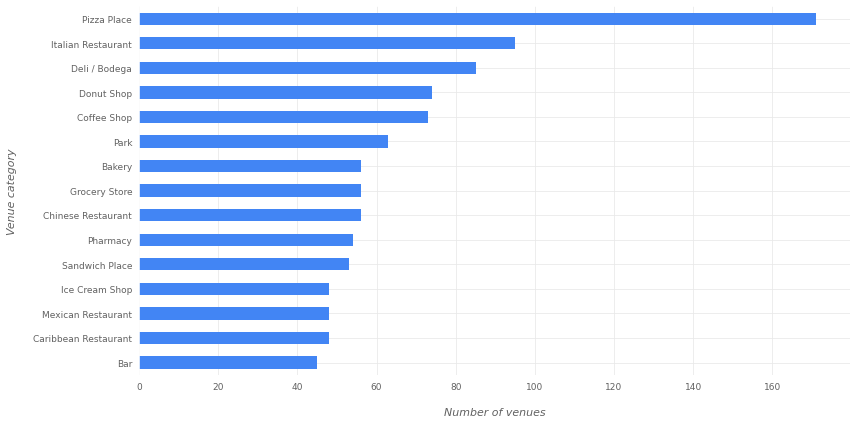

In [369]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='#ffffff')
NY_top_vc = NY_venues['Venue Category'].value_counts(normalize=False)
ax = NY_top_vc.head(15).plot(kind='barh', color= "#4285f4");
ax.invert_yaxis()

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
display_format = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-venues-New_York.png', dpi=300)

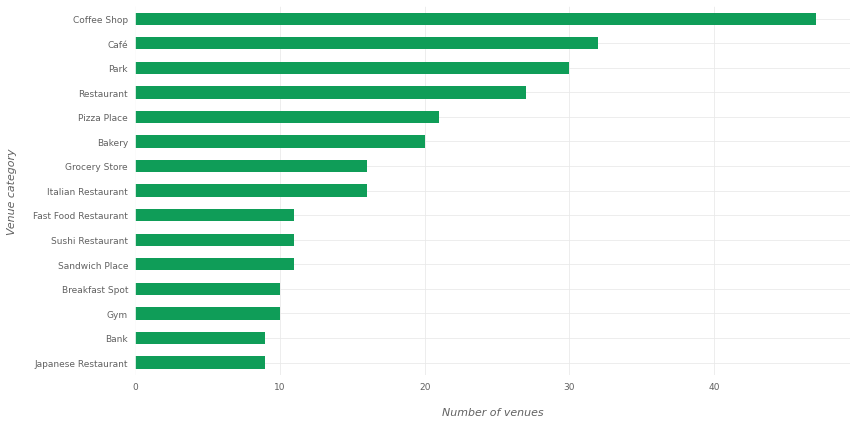

In [370]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='#ffffff')
TO_top_vc = toronto_venues['Venue Category'].value_counts(normalize=False)
ax = TO_top_vc.head(15).plot(kind='barh', color= "#0f9d58");
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-venues-Toronto.png', dpi=300)

In [371]:
NY_bot_vc = NY_venues['Venue Category'].value_counts(normalize=False)
NY_bot_vc = NY_bot_vc.tail(15).to_frame('Count')
NY_bot_vc.index.names = ['Venue Category']
NY_bot_vc

,Count
Venue Category,
Entertainment Service,1
Tibetan Restaurant,1
Poke Place,1
Office,1
Outdoor Sculpture,1
Empanada Restaurant,1
Rest Area,1
Jewelry Store,1
Cooking School,1


In [372]:
TO_bot_vc = toronto_venues['Venue Category'].value_counts(normalize=False)
TO_bot_vc = TO_bot_vc.tail(15).to_frame('Count')
TO_bot_vc.index.names = ['Venue Category']
TO_bot_vc

,Count
Venue Category,
Video Store,1
Accessories Store,1
Distribution Center,1
French Restaurant,1
Massage Studio,1
Falafel Restaurant,1
Lake,1
Wings Joint,1
Moving Target,1


# Battle of Neighborhoods - New York and Toronto - Combined

In [373]:
only_NY_columns = set(NY_grouped.columns).difference(set(toronto_grouped.columns))
only_TO_columns = set(toronto_grouped.columns).difference(set(NY_grouped.columns))

In [415]:
NY_grouped_ = NY_grouped.copy()
NY_grouped_['Neighborhood'] = NY_grouped_['Neighborhood'].apply(lambda x: x + '_NYC')
toronto_grouped_ = toronto_grouped.copy()
toronto_grouped_['Neighborhood'] = toronto_grouped_['Neighborhood'].apply(lambda x: x + '_Toronto')

for c in only_TO_columns:
    NY_grouped_[c] = 0
for c in only_NY_columns:
    toronto_grouped_[c] = 0
    
All_columns_sorted = ['Neighborhood'] + sorted(list(NY_grouped_.drop('Neighborhood', axis=1).columns), key=str.lower)
NY_grouped_ = NY_grouped_[All_columns_sorted]
toronto_grouped_ = toronto_grouped_[all_clmns_sorted]
    
NY_TO_grouped = pd.concat([NY_grouped_, toronto_grouped_]).reset_index(drop=True)

In [416]:
NY_TO_grouped.loc[300:308,]

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,BBQ Joint,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Check Cashing Service,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Puerto Rican Restaurant,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,River

In [417]:
NY_TO_grouped.shape

(395, 354)

In [418]:
# obtaining the most popular categories for each neighborhood
NY_TO_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
NY_TO_neighborhoods_categories_sorted['Neighborhood'] = NY_TO_grouped['Neighborhood']

for ind in np.arange(NY_TO_grouped.shape[0]):
    NY_TO_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        NY_TO_grouped.iloc[ind, :], num_top_venues)

NY_TO_neighborhoods_categories_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton_NYC_NYC_NYC,Pizza Place,Breakfast Spot,Supermarket,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Dessert Shop,Gas Station,Martial Arts School,Yoga Studio
1,Annadale_NYC_NYC_NYC,Pizza Place,Diner,Pharmacy,Restaurant,Park,American Restaurant,Train Station,Dance Studio,Food,Empanada Restaurant
2,Arden Heights_NYC_NYC_NYC,Coffee Shop,Deli / Bodega,Pizza Place,Bus Stop,Pharmacy,Yoga Studio,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
3,Arlington_NYC_NYC_NYC,Arcade,Scenic Lookout,Deli / Bodega,American Restaurant,Bus Stop,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service
4,Arrochar_NYC_NYC_NYC,Italian Restaurant,Mediterranean Restaurant,Polish Restaurant,Middle Eastern Restaurant,Bagel Shop,Deli / Bodega,Pizza Place,Supermarket,Outdoors & Recreation,Event Space
5,Arverne_NYC_NYC_NYC,Surf Spot,Coffee Shop,Donut Shop,Sandwich Place,Pizza Place,Board Shop,Beach,Thai Restaurant,Event Service,Duty-free Shop
6,Astoria_NYC_NYC_NYC,Gym,Gourmet Shop,Pub,Brazilian Restaurant,Martial Arts School,Middle Eastern Restaurant,Seafood Restaurant,Indian Restaurant,Airport Terminal,Farm
7,Astoria Heights_NYC_NYC_NYC,Bakery,Food,Hostel,Bowling Alley,Plaza,Italian Restaurant,Deli / Bodega,Pizza Place,Supermarket,Burger Joint
8,Auburndale_NYC_NYC_NYC,Miscellaneous Shop,American Restaurant,Pet Store,Pharmacy,Toy / Game Store,Mattress Store,Athletics & Sports,Italian Restaurant,Fast Food Restaurant,Discount Store
9,Bath Beach_NYC_NYC_NYC,Dessert Shop,Burger Joint,Sushi Restaurant,Turkish Restaurant,German Restaurant,Surf Spot,Park,Italian Restaurant,Hookah Bar,Ice Cream Shop


### Most Common Venue Categories in both NYC and GTA

In [419]:
# fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
# NY_TO_top_vc = pd.concat([NY_venues, toronto_venues])['Venue Category'].value_counts(normalize=True) * 100
# ax = NY_TO_top_vc.head(15).plot(kind='barh', color=pc[12]);
# ax.invert_yaxis()
# plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
# fig.savefig('most-common-ven-nyc-tor.png', dpi=300)

### Rare Categories in both NYC and GTA

In [420]:
NY_TO_bot_vc = pd.concat([NY_venues, toronto_venues])['Venue Category'].value_counts(normalize=False)
NY_TO_bot_vc = NY_TO_bot_vc.tail(15).to_frame('Count')
NY_TO_bot_vc.index.names = ['Venue Category']
NY_TO_bot_vc

,Count
Venue Category,
College Arts Building,1
Plane,1
Christmas Market,1
Pet Café,1
Dumpling Restaurant,1
Modern European Restaurant,1
Swim School,1
Distribution Center,1
Motel,1


### Combined Clustering of New York and Toronto

In [421]:
# the number of clusters
kclusters = 5

NY_TO_grouped_clustering = NY_TO_grouped.drop('Neighborhood', 1)

# run k-means clustering
Combined_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_TO_grouped_clustering)

# check cluster labels generated for each row in the dataframe
Combined_kmeans.labels_[0:10]

array([4, 4, 4, 0, 4, 0, 0, 4, 1, 0], dtype=int32)

In [422]:
# add clustering labels
NY_TO_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', Combined_kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NY_TO_merged = NY_TO_neighborhoods_categories_sorted.set_index('Neighborhood')

NY_TO_merged.iloc[300:310] # check the last columns!

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Yorkville_NYC_NYC_NYC,0,Deli / Bodega,Diner,Bagel Shop,Park,Gym,Coffee Shop,Hobby Shop,Liquor Store,Wine Shop,Farmers Market
Agincourt_Toronto,0,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service
"Alderwood, Long Branch_Toronto",4,Pizza Place,Pub,Coffee Shop,Gym,Sandwich Place,Pharmacy,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop
"Bathurst Manor, Wilson Heights, Downsview North_Toronto",4,Coffee Shop,Bridal Shop,Deli / Bodega,Restaurant,Sushi Restaurant,Pizza Place,Bank,Middle Eastern Restaurant,Ice Cream Shop,Event Space
Bayview Village_Toronto,0,Chinese Restaurant,Japanese Restaurant,Café,Bank,Fish & Chips Shop,Flea Market,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
"Bedford Park, Lawrence Manor East_Toronto",0,Sushi Restaurant,Greek Restaurant,Juice Bar,Café,Comfort Food Restaurant,Italian Restaurant,Restaurant,Pub,Thai Restaurant,Indian Restaurant
Berczy Park_Toronto,0,Farmers Market,Cocktail Bar,Liquor Store,Concert Hall,Museum,Fountain,Park,Restaurant,Vegetarian / Vegan Restaurant,Yoga Studio
"Birch Cliff, Cliffside West_Toronto",0,General Entertainment,Café,College Stadium,Skating Rink,Yoga Studio,Event Service,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
"Brockton, Parkdale Village, Exhibition Place_Toronto",0,Breakfast Spot,Coffee Shop,Bar,Gym,Café,Pet Store,Furniture / Home Store,Italian Restaurant,Fast Food Restaurant,Event Service


**Cluster 1**

In [423]:
c1 = NY_TO_merged.loc[NY_TO_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c1

(208, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Arlington_NYC_NYC_NYC,0,Arcade,Scenic Lookout,Deli / Bodega,American Restaurant,Bus Stop,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service
Arverne_NYC_NYC_NYC,0,Surf Spot,Coffee Shop,Donut Shop,Sandwich Place,Pizza Place,Board Shop,Beach,Thai Restaurant,Event Service,Duty-free Shop
Astoria_NYC_NYC_NYC,0,Gym,Gourmet Shop,Pub,Brazilian Restaurant,Martial Arts School,Middle Eastern Restaurant,Seafood Restaurant,Indian Restaurant,Airport Terminal,Farm
Bath Beach_NYC_NYC_NYC,0,Dessert Shop,Burger Joint,Sushi Restaurant,Turkish Restaurant,German Restaurant,Surf Spot,Park,Italian Restaurant,Hookah Bar,Ice Cream Shop
Battery Park City_NYC_NYC_NYC,0,Food Court,Cooking School,Smoke Shop,Cupcake Shop,Shopping Mall,Plaza,Park,Gym,Performing Arts Venue,Dumpling Restaurant
Bay Ridge_NYC_NYC_NYC,0,Spa,Breakfast Spot,Pizza Place,Bagel Shop,Greek Restaurant,Grocery Store,Taco Place,Juice Bar,Caucasian Restaurant,Farm
Bay Terrace_NYC_NYC_NYC,0,Supermarket,Donut Shop,Cosmetics Shop,Italian Restaurant,Salon / Barbershop,Bakery,Shipping Store,Furniture / Home Store,Sushi Restaurant,Shopping Mall
Bayside_NYC_NYC_NYC,0,Greek Restaurant,Indian Restaurant,Steakhouse,Bar,Noodle House,Bistro,Bakery,Spa,Wine Bar,Filipino Restaurant
Bedford Stuyvesant_NYC_NYC_NYC,0,Juice Bar,Wine Shop,Gift Shop,New American Restaurant,Bar,Boutique,Coffee Shop,Italian Restaurant,Fried Chicken Joint,Japanese Restaurant


In [424]:
c2 = NY_TO_merged.loc[NY_TO_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c2

(73, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Auburndale_NYC_NYC_NYC,1,Miscellaneous Shop,American Restaurant,Pet Store,Pharmacy,Toy / Game Store,Mattress Store,Athletics & Sports,Italian Restaurant,Fast Food Restaurant,Discount Store
Baychester_NYC_NYC_NYC,1,Mattress Store,Spanish Restaurant,Bank,Supermarket,Pizza Place,Donut Shop,Sandwich Place,Fried Chicken Joint,Gym / Fitness Center,Discount Store
Broadway Junction_NYC_NYC_NYC,1,Donut Shop,Breakfast Spot,Burger Joint,Caribbean Restaurant,Sandwich Place,Gas Station,Fried Chicken Joint,Diner,Ice Cream Shop,Fast Food Restaurant
Cambria Heights_NYC_NYC_NYC,1,Caribbean Restaurant,Flower Shop,Gym / Fitness Center,Restaurant,Pharmacy,Nightclub,Liquor Store,Bakery,Cosmetics Shop,History Museum
Canarsie_NYC_NYC_NYC,1,Gym,Thai Restaurant,Asian Restaurant,Caribbean Restaurant,Yoga Studio,Dry Cleaner,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
Chinatown_NYC_NYC_NYC,1,Chinese Restaurant,Sandwich Place,Cocktail Bar,Bakery,Hotel,Spa,Greek Restaurant,Pizza Place,Yoga Studio,Dumpling Restaurant
City Line_NYC_NYC_NYC,1,Ice Cream Shop,Video Game Store,Pharmacy,Sandwich Place,Donut Shop,Fast Food Restaurant,South American Restaurant,Bank,Latin American Restaurant,Mobile Phone Shop
Claremont Village_NYC_NYC_NYC,1,Grocery Store,Discount Store,Pizza Place,Chinese Restaurant,Caribbean Restaurant,Gym,Park,Pharmacy,Check Cashing Service,Factory
Concourse_NYC_NYC_NYC,1,Ice Cream Shop,Pharmacy,Spanish Restaurant,Fried Chicken Joint,Caribbean Restaurant,Chinese Restaurant,Grocery Store,Art Museum,Bakery,Italian Restaurant


In [425]:
c3 = NY_TO_merged.loc[NY_TO_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c3

(13, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Clason Point_NYC_NYC_NYC,2,Park,Pool,Convenience Store,Grocery Store,Boat or Ferry,South American Restaurant,Bus Stop,Yoga Studio,Event Service,Duty-free Shop
Somerville_NYC_NYC_NYC,2,Park,Yoga Studio,Dry Cleaner,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
Todt Hill_NYC_NYC_NYC,2,Park,Yoga Studio,Dry Cleaner,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
Caledonia-Fairbanks_Toronto,2,Park,Women's Store,Pool,Yoga Studio,Event Space,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
"East Toronto, Broadview North (Old East York)_Toronto",2,Park,Convenience Store,Intersection,Event Space,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service
Lawrence Park_Toronto,2,Business Service,Park,Swim School,Bus Line,Yoga Studio,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service
"Milliken, Agincourt North, Steeles East, L'Amoreaux East_Toronto",2,Park,Intersection,Playground,Arts & Crafts Store,Yoga Studio,Event Space,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
"Moore Park, Summerhill East_Toronto",2,Lawyer,Park,Trail,Restaurant,Ethiopian Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant
"North Park, Maple Leaf Park, Upwood Park_Toronto",2,Construction & Landscaping,Park,Basketball Court,Bakery,Yoga Studio,Event Space,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant


In [426]:
c4 = NY_TO_merged.loc[NY_TO_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c4

(3, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Bayswater_NYC_NYC_NYC,3,Playground,Yoga Studio,Factory,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
Edenwald_NYC_NYC_NYC,3,Playground,Grocery Store,Supermarket,Yoga Studio,Event Service,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
Scarborough Village_Toronto,3,Playground,Yoga Studio,Factory,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service


In [427]:
c5 = NY_TO_merged.loc[NY_TO_merged['Cluster Labels'] == 4, :]
print(c5.shape)
c5

(98, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Allerton_NYC_NYC_NYC,4,Pizza Place,Breakfast Spot,Supermarket,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Dessert Shop,Gas Station,Martial Arts School,Yoga Studio
Annadale_NYC_NYC_NYC,4,Pizza Place,Diner,Pharmacy,Restaurant,Park,American Restaurant,Train Station,Dance Studio,Food,Empanada Restaurant
Arden Heights_NYC_NYC_NYC,4,Coffee Shop,Deli / Bodega,Pizza Place,Bus Stop,Pharmacy,Yoga Studio,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant
Arrochar_NYC_NYC_NYC,4,Italian Restaurant,Mediterranean Restaurant,Polish Restaurant,Middle Eastern Restaurant,Bagel Shop,Deli / Bodega,Pizza Place,Supermarket,Outdoors & Recreation,Event Space
Astoria Heights_NYC_NYC_NYC,4,Bakery,Food,Hostel,Bowling Alley,Plaza,Italian Restaurant,Deli / Bodega,Pizza Place,Supermarket,Burger Joint
Bedford Park_NYC_NYC_NYC,4,Diner,Pizza Place,Pub,Mexican Restaurant,Park,Deli / Bodega,Italian Restaurant,Event Space,Duty-free Shop,Eastern European Restaurant
Beechhurst_NYC_NYC_NYC,4,Donut Shop,Chinese Restaurant,Supermarket,Deli / Bodega,Italian Restaurant,Pizza Place,Park,Dessert Shop,Gym / Fitness Center,Salad Place
Bellerose_NYC_NYC_NYC,4,Pub,Italian Restaurant,Pizza Place,Deli / Bodega,Diner,Donut Shop,Seafood Restaurant,American Restaurant,Mobile Phone Shop,Wine Shop
Belmont_NYC_NYC_NYC,4,Dessert Shop,Food & Drink Shop,Italian Restaurant,Pizza Place,Fish Market,Deli / Bodega,Factory,Eastern European Restaurant,Electronics Store,Empanada Restaurant


In [428]:
cluster_categories = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    cluster_categories.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            cluster_categories[i].extend(list(NY_venues[NY_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            cluster_categories[i].extend(list(toronto_venues[toronto_venues['Neighborhood'] == nn]['Venue Category'].values))
    cluster_categories[i] = pd.Series(cluster_categories[i]).value_counts(normalize=True) * 100

In [429]:
table_color = "#363636"
table_header_color = "#363636"
tabl_txt_color = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

In [430]:
for i in range(kclusters):
    c__ = cluster_categories[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(display_format.format("Cluster {}".format(i+1))))
    display(html)

,% of venues
Category,
Coffee Shop,7.766990
Café,6.213592
Restaurant,4.854369
Bakery,3.106796
Italian Restaurant,2.912621
Park,2.718447
Sushi Restaurant,1.941748


,% of venues
Category,
Grocery Store,11.842105
Fast Food Restaurant,9.210526
Bank,5.263158
Sandwich Place,5.263158
Pharmacy,3.947368
Pizza Place,3.947368
Gas Station,3.947368


,% of venues
Category,
Park,35.294118
Intersection,5.882353
Trail,5.882353
Convenience Store,5.882353
Playground,5.882353
Arts & Crafts Store,2.941176
Baseball Field,2.941176


,% of venues
Category,
Playground,100.000000


,% of venues
Category,
Pizza Place,19.354839
Coffee Shop,9.677419
Sandwich Place,6.451613
Pharmacy,4.838710
Park,3.225806
Bus Line,3.225806
Pub,3.225806


In [431]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

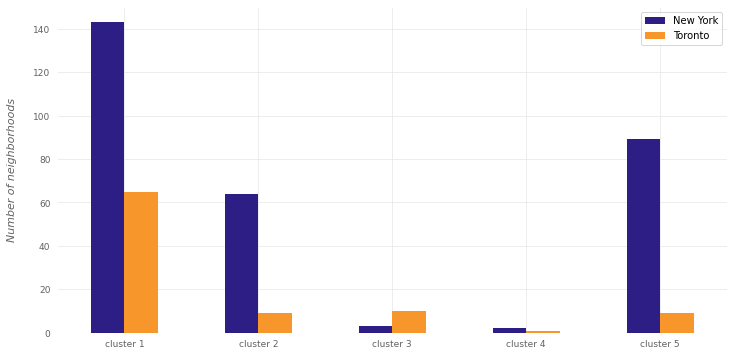

In [432]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'New York': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=(12,6), facecolor='#ffffff')
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
fig.savefig('city-count.png', dpi=300)

# END! I hope you liked the work!